In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [13]:
# Finding hedge ratio and entry exit conditions

df1 = pd.read_excel('./excels/GLD.xlsx')
df2 = pd.read_excel('./excels/GDX.xlsx')
df = pd.merge(df1, df2, on='Date', suffixes=('_GLD', '_GDX'))
df.sort_values(by='Date', inplace=True)

trainset_range = 900
model = sm.OLS(df['Close_GLD'].iloc[:trainset_range],
             df['Close_GDX'].iloc[:trainset_range]) # ordinary least squares 
results = model.fit()
hedgeRatio = results.params # gradient of GLD against GDX
print("hedgeRatio:", hedgeRatio.iloc[0])

spread = df['Close_GLD'] - hedgeRatio.iloc[0]*df['Close_GDX']

spreadMean = np.mean(spread.iloc[trainset])
print("spreadMean: ", spreadMean)
spreadStd = np.std(spread.iloc[trainset])
print("spreadStd:", spreadStd)
df['zscore'] = (spread-spreadMean)/spreadStd
df['positions_GLD_Long'] = 0
df['positions_GDX_Long'] = 0
df['positions_GLD_Short'] = 0
df['positions_GDX_Short'] = 0
df.loc[df.zscore >= 0.4, ('positions_GLD_Short', 'positions_GDX_Short')] = [-1, 1]  # Short spread
df.loc[df.zscore <= -0.4, ('positions_GLD_Long', 'positions_GDX_Long')] = [1, -1]  # Buy spread
df.loc[df.zscore < 0, ('positions_GLD_Short', 'positions_GDX_Short')] = 0  # Exit short spread
df.loc[df.zscore > 0, ('positions_GLD_Long', 'positions_GDX_Long')] = 0  # Exit long spread
df.ffill(inplace=True)  # ensure existing positions are carried forward unless there is an exit signal

hedgeRatio: 5.90876926061392
spreadMean:  2.890206686042017
spreadStd: 15.829316874548304


In [15]:
# Derive resulting positions

df['net_positions_GLD'] = df['positions_GLD_Long'] + df['positions_GLD_Short']
df['net_positions_GDX'] = df['positions_GDX_Long'] + df['positions_GDX_Short']
df[['net_positions_GLD_lagged', 'net_positions_GDX_lagged']] = df[['net_positions_GLD', 'net_positions_GDX']].shift(1)
df[['GLD_returns', 'GDX_returns']] = df[['Close_GLD', 'Close_GDX']].pct_change()
df['strategy_returns'] = (df['net_positions_GLD_lagged'] * df['GLD_returns'] +
                          df['net_positions_GDX_lagged'] * df['GDX_returns'])
df['strategy_return'] = df['strategy_returns'].fillna(0)

sharpeTrainset: 0.8282403183199433
sharpeTestset: 0.885703792364647
      positions_GLD_Long  positions_GDX_Long  positions_GLD_Short  \
2504                   1                  -1                    0   
2505                   1                  -1                    0   
2506                   1                  -1                    0   
2507                   0                   0                    0   
2508                   0                   0                    0   
2509                   0                   0                    0   
2510                   0                   0                    0   
2511                   0                   0                    0   
2512                   1                  -1                    0   
2513                   0                   0                    0   

      positions_GDX_Short  
2504                    0  
2505                    0  
2506                    0  
2507                    0  
2508                    0  
2509

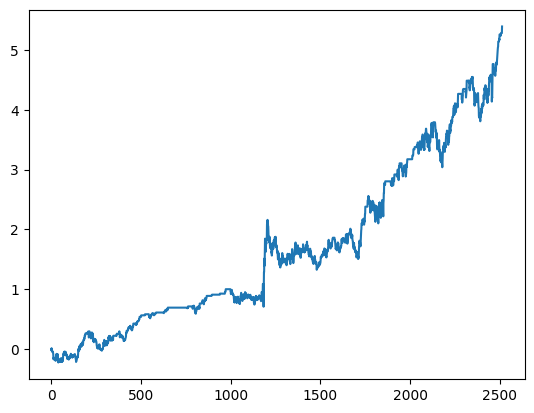

In [17]:
# Trainset and Testset Sharpe Ratios

sharpeTrainset = np.sqrt(252) * np.mean(df['strategy_return'].iloc[:trainset_range]) / np.std(df['strategy_return'].iloc[:trainset_range])
print("sharpeTrainset:", sharpeTrainset)
sharpeTestset = np.sqrt(252) * np.mean(df['strategy_return'].iloc[trainset_range:]) / np.std(df['strategy_return'].iloc[trainset_range:])
print("sharpeTestset:", sharpeTestset)

print(df[['positions_GLD_Long', 'positions_GDX_Long',
          'positions_GLD_Short', 'positions_GDX_Short']].tail(10))
cumret = np.cumprod(1 + df['strategy_return']) - 1
plt.plot(cumret)
plt.show()

In [19]:
from _03_drawdowns import calculateMaxDD

maxDD, maxDDD, startDDDay = calculateMaxDD(cumret.values)
print("maxDD:", maxDD)
print("maxDDD:", maxDDD)
print("Start of DD:", startDDDay)


maxDD: -0.26446823168884226
maxDDD: 529.0
Start of DD: 1480
